
# Robot Controller Accuracy Test (ROS 2)

This notebook publishes a matrix of target joint states to your robot controller, waits for the robot to settle (low joint velocities), and records the absolute error between the directed (commanded) and reported joint positions from `/joint_states`.

**What it does:**
1. Subscribes to **`/joint_states`** to read joint positions and velocities.
2. Publishes joint position goals to **`/scaled_joint_trajectory_controller/joint_trajectory`** (configurable).
3. For each target:
   - Sends a **JointTrajectory** goal (positions only).
   - Waits until measured joint velocities are below a configurable threshold for a short window.
   - Captures the reported joint positions and computes **absolute error** per joint.
4. Accumulates errors into a NumPy matrix of shape **(N, J)** and saves results (**.npy** and **.csv**).

> **Note:** Run this notebook on the same machine / network as your ROS 2 graph (e.g., Humble). Make sure you have access to the robot or simulator topics.


In [440]:

# If you're running in a fresh environment, you may need these:
# !pip install numpy matplotlib rclpy --extra-index-url https://rospypi.github.io/simple

import time
import threading
from collections import deque
from typing import List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

import rclpy
from rclpy.node import Node
from rclpy.qos import QoSProfile, HistoryPolicy, ReliabilityPolicy, DurabilityPolicy
from sensor_msgs.msg import JointState
from trajectory_msgs.msg import JointTrajectory, JointTrajectoryPoint


In [441]:


# set random seed for reproducibility
np.random.seed(4)
# ==== Configuration ====
JOINT_STATE_TOPIC = '/joint_states'  # Where the robot publishes joint states
TRAJ_TOPIC = '/scaled_joint_trajectory_controller/joint_trajectory'  # Where we publish commands

# If None, we will infer order from first /joint_states message (first J joints)
JOINT_NAMES: Optional[List[str]] = None

# Number of joints to test (if JOINT_NAMES is None we take first J from received state)
J = 7  # e.g., for a 7-DOF arm; set 8 if you include a gripper joint position

# Settle detection
VELOCITY_THRESHOLD = 0.05          # rad/s; consider system "settled" below this
SETTLE_WINDOW = 10                  # consecutive samples below threshold
#JOINT_STATES_RATE_HINT = 60.0      # Hz estimate to size buffers/timeouts
SETTLE_TIMEOUT = 5.0               # seconds max to wait for settling per target
HOLD_AFTER_SETTLE = 0.2            # seconds to hold after settle before sampling

# Publishing
POINT_TIME_FROM_START = 1.0         # seconds; controller interprets as move duration
PUBLISH_SLEEP = 0.05                 # small delay after publish

mean_target =  np.array([
        0.011335312069000092,
        0.2720501795277465,
        -0.01088267017501314,
        -2.01687728054916,
        -0.036302827384647,
        2.3479571350249087,
        0.09651094572890309,
        0.39627546938562525
      ])
offset = np.array([
           0.0,
           0.0,
           0.0,
           0.0,
           0.0,
           0.0,
           0.0,
           0.0,
      ])

std_target = np.array([
        0.31480194797319616,
        0.4886056857285085,
        0.2738964198316734,
        0.48531355558421696,
        0.5218106716806459,
        0.4563026725101075,
        0.7445646573567261,
        0.40620681894754745
      ])



# Targets: create a matrix of N x J joint targets (radians)
# Example: sweep each joint a little around zero
N = 20
TARGETS = np.zeros((N, J), dtype=np.float64)
for i in range(N):
    # draw random samples from the normal distribution
    delta = np.random.normal(mean_target+offset, 0.1*std_target)
    for j in range(J):
        TARGETS[i, j] = delta[j]

# Output files
OUT_PREFIX = '/tmp'


In [442]:

class JointMonitor(Node):
    def __init__(self, joint_state_topic: str):
        super().__init__('joint_monitor')
        qos = QoSProfile(
            depth=50,
            history=HistoryPolicy.KEEP_LAST,
            reliability=ReliabilityPolicy.RELIABLE,
        )
        self._lock = threading.Lock()
        self.names: Optional[List[str]] = None
        self.pos: Optional[np.ndarray] = None
        self.vel: Optional[np.ndarray] = None
        self.t_last: float = time.time()
        self._vel_ring = deque(maxlen=200)  # for settle window
        self._sub = self.create_subscription(JointState, joint_state_topic, self._cb, qos)

    def _cb(self, msg: JointState):
        with self._lock:
            if self.names is None:
                self.names = list(msg.name)
            self.pos = np.array(msg.position, dtype=np.float64) if msg.position else None
            self.vel = np.array(msg.velocity, dtype=np.float64) if msg.velocity else None
            if self.vel is not None and len(self.vel) > 0:
                self._vel_ring.append(np.abs(self.vel))
            self.t_last = time.time()

    def latest(self) -> Tuple[Optional[List[str]], Optional[np.ndarray], Optional[np.ndarray]]:
        with self._lock:
            return (self.names, None if self.pos is None else self.pos.copy(),
                    None if self.vel is None else self.vel.copy())

    def settled(self, joint_indices: List[int], v_thresh: float, window: int) -> bool:
        # Require we have at least `window` velocity samples
        if len(self._vel_ring) < window:
            return False
        # Check the last `window` samples: all |v_j| < v_thresh for all requested joints
        for k in range(1, window + 1):
            v = self._vel_ring[-k]
            if v is None or len(v) <= max(joint_indices):
                return False
            if np.any(v[joint_indices] >= v_thresh):
                return False
        return True


In [443]:

class TrajectoryCommander(Node):
    def __init__(self, traj_topic: str, joint_names: List[str]):
        super().__init__('trajectory_commander')
        qos = QoSProfile(
            depth=10,
            history=HistoryPolicy.KEEP_LAST,
            reliability=ReliabilityPolicy.RELIABLE,
            durability=DurabilityPolicy.VOLATILE,
        )
        self._pub = self.create_publisher(JointTrajectory, traj_topic, qos)
        self._joint_names = list(joint_names)

    def send_target(self, q_target: np.ndarray, move_time: float = 1.0):
        jt = JointTrajectory()
        jt.joint_names = self._joint_names
        pt = JointTrajectoryPoint()
        pt.positions = q_target.tolist()
        pt.time_from_start.sec = int(move_time)
        pt.time_from_start.nanosec = int((move_time - int(move_time)) * 1e9)
        jt.points.append(pt)
        self._pub.publish(jt)


In [444]:

def run_accuracy_test(
    targets: np.ndarray,
    joint_state_topic: str = JOINT_STATE_TOPIC,
    traj_topic: str = TRAJ_TOPIC,
    configured_joint_names: Optional[List[str]] = JOINT_NAMES,
    velocity_threshold: float = VELOCITY_THRESHOLD,
    settle_window: int = SETTLE_WINDOW,
    settle_timeout: float = SETTLE_TIMEOUT,
    hold_after_settle: float = HOLD_AFTER_SETTLE,
    move_time: float = POINT_TIME_FROM_START,
    publish_sleep: float = PUBLISH_SLEEP,
    j_count: int = J,
):
    assert targets.ndim == 2 and targets.shape[1] == j_count, "targets must be (N, J)"
    rclpy.init(args=None)
    jm = JointMonitor(joint_state_topic)
    executor = rclpy.executors.MultiThreadedExecutor()
    executor.add_node(jm)

    # Spin up a thread to process callbacks
    spinning = True
    def spin():
        while spinning:
            rclpy.spin_once(jm, timeout_sec=0.05)
    t = threading.Thread(target=spin, daemon=True)
    t.start()

    # Wait for first joint state
    print("Waiting for /joint_states...")
    start_wait = time.time()
    while True:
        names, pos, vel = jm.latest()
        if pos is not None and names is not None and len(pos) >= j_count:
            break
        if time.time() - start_wait > 10.0:
            spinning = False
            t.join(timeout=1.0)
            jm.destroy_node()
            rclpy.shutdown()
            raise RuntimeError("Timed out waiting for /joint_states.")
        time.sleep(0.05)

    if configured_joint_names is None:
        joint_names = names[:j_count]
        joint_indices = list(range(j_count))
    else:
        joint_names = list(configured_joint_names)
        # Build indices mapping from names in the message
        name_to_idx = {n: i for i, n in enumerate(names)}
        joint_indices = [name_to_idx[n] for n in joint_names]

    print("Using joint order:", joint_names)

    # Create commander
    tc = TrajectoryCommander(traj_topic, joint_names)
    executor.add_node(tc)

    # Error accumulation
    N_local = targets.shape[0]
    abs_errors = np.zeros((N_local, j_count), dtype=np.float64)
    reported_positions = np.zeros((N_local, j_count), dtype=np.float64)

    for i in range(N_local):
        q_cmd = targets[i].copy()
        # Publish command
        tc.send_target(q_cmd, move_time=move_time)
        time.sleep(publish_sleep)

        # Wait for settle or timeout
        t0 = time.time()
        settled_flag = False
        while time.time() - t0 < settle_timeout:
            if jm.settled(joint_indices, velocity_threshold, settle_window):
                settled_flag = True
                break
            time.sleep(0.01)

        if not settled_flag:
            print(f"[{i}] WARNING: settle timeout after {settle_timeout}s")

        # Small hold then sample
        time.sleep(hold_after_settle)
        _, pos, _ = jm.latest()
        if pos is None:
            raise RuntimeError("Lost /joint_states during test.")

        q_rep = pos[joint_indices]
        reported_positions[i, :] = q_rep
        abs_errors[i, :] = np.abs(q_cmd - q_rep)

        print(f"[{i}] max|err| = {abs_errors[i, :].max():.4f} rad")

    # Tear down
    spinning = False
    t.join(timeout=1.0)
    executor.remove_node(tc)
    executor.remove_node(jm)
    tc.destroy_node()
    jm.destroy_node()
    rclpy.shutdown()

    return joint_names, reported_positions, abs_errors


In [445]:

# Run the test
joint_names_used, reported, abs_err = run_accuracy_test(TARGETS)

print("Test complete.")
print("Targets shape:", TARGETS.shape)
print("Reported shape:", reported.shape)
print("Abs error shape:", abs_err.shape)

# # Save results
# np.save(OUT_PREFIX + '_targets.npy', TARGETS)
# np.save(OUT_PREFIX + '_reported.npy', reported)
# np.save(OUT_PREFIX + '_abs_error.npy', abs_err)

# # Also save CSVs
# np.savetxt(OUT_PREFIX + '_targets.csv', TARGETS, delimiter=',')
# np.savetxt(OUT_PREFIX + '_reported.csv', reported, delimiter=',')
# np.savetxt(OUT_PREFIX + '_abs_error.csv', abs_err, delimiter=',')

# print("Saved to:", OUT_PREFIX + "_{targets,reported,abs_error}.{npy,csv}")
print("Joint order used:", joint_names_used)


Waiting for /joint_states...
Using joint order: ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']
[0] max|err| = 0.0001 rad
[1] max|err| = 0.0027 rad
[2] max|err| = 0.0002 rad
[3] max|err| = 0.0642 rad
[4] max|err| = 0.0002 rad
[5] max|err| = 0.0204 rad
[6] max|err| = 0.0002 rad
[7] max|err| = 0.0104 rad
[8] max|err| = 0.0001 rad
[9] max|err| = 0.0004 rad
[10] max|err| = 0.0002 rad
[11] max|err| = 0.0347 rad
[12] max|err| = 0.0001 rad
[13] max|err| = 0.0317 rad
[14] max|err| = 0.0001 rad
[15] max|err| = 0.0368 rad
[16] max|err| = 0.0001 rad
[17] max|err| = 0.0445 rad
[18] max|err| = 0.0001 rad
[19] max|err| = 0.0145 rad
Test complete.
Targets shape: (20, 7)
Reported shape: (20, 7)
Abs error shape: (20, 7)
Joint order used: ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']


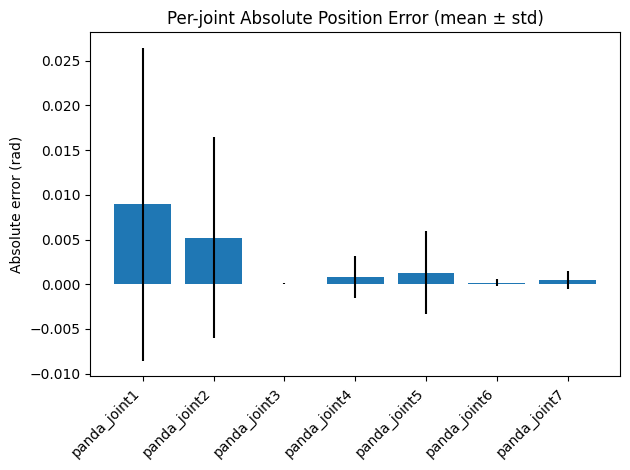

panda_joint1: 0.0642 rad, 3.68 deg
panda_joint2: 0.0445 rad, 2.55 deg
panda_joint3: 0.0003 rad, 0.02 deg
panda_joint4: 0.0104 rad, 0.60 deg
panda_joint5: 0.0215 rad, 1.23 deg
panda_joint6: 0.0018 rad, 0.10 deg
panda_joint7: 0.0037 rad, 0.21 deg
Total max absolute error across all joints: 0.1464 rad, 8.39 deg


In [446]:

# Quick visualization of per-joint errors
# (Per instructions: use matplotlib, single plot, no explicit colors/styles)
mean_err = abs_err.mean(axis=0)
std_err = abs_err.std(axis=0)

plt.figure()
x = np.arange(len(mean_err))
plt.bar(x, mean_err, yerr=std_err)
plt.xticks(x, joint_names_used, rotation=45, ha='right')
plt.ylabel('Absolute error (rad)')
plt.title('Per-joint Absolute Position Error (mean ± std)')
plt.tight_layout()
plt.show()

# display the max error for each joint
for i in range(7):
    print(f"{joint_names_used[i]}: {abs_err.max(axis=0)[i]:0.4f} rad, {abs_err.max(axis=0)[i]*180/np.pi:0.2f} deg")

# sum of all the max abs errors
total_max_error = abs_err.max(axis=0).sum()
print(f"Total max absolute error across all joints: {total_max_error:0.4f} rad, {total_max_error*180/np.pi:0.2f} deg")


In [127]:

# Preview a few rows of target vs. reported vs. abs error
import pandas as pd
preview_rows = TARGETS.shape[0]
df = pd.DataFrame(
    np.hstack([TARGETS[:preview_rows], reported[:preview_rows], abs_err[:preview_rows]]),
    columns=[*(f"tgt_{n}" for n in joint_names_used),
             *(f"rep_{n}" for n in joint_names_used),
             *(f"err_{n}" for n in joint_names_used)]
)

df.head(preview_rows)


,tgt_panda_joint1,tgt_panda_joint2,tgt_panda_joint3,tgt_panda_joint4,tgt_panda_joint5,tgt_panda_joint6,tgt_panda_joint7,rep_panda_joint1,rep_panda_joint2,rep_panda_joint3,...,rep_panda_joint5,rep_panda_joint6,rep_panda_joint7,err_panda_joint1,err_panda_joint2,err_panda_joint3,err_panda_joint4,err_panda_joint5,err_panda_joint6,err_panda_joint7
0,0.019294,0.394190,-0.147271,-1.848571,-0.145440,1.986434,-0.144619,0.0193,0.3942,-0.1473,...,-0.1454,1.9864,-0.1446,6.225980e-06,0.000010,0.000029,0.000029,3.992595e-05,0.000034,1.883784e-05
1,0.063632,-0.008282,0.073843,-2.038228,0.074601,2.423761,-0.334151,0.0636,0.1755,-0.1118,...,0.0745,2.4092,-0.3340,3.179081e-05,0.183782,0.185643,0.000028,1.008290e-04,0.014561,1.513057e-04
2,-0.084189,0.649982,0.088178,-2.005682,-0.292771,2.360376,0.156036,-0.0842,0.6500,0.0882,...,-0.2928,2.3604,0.1560,1.066261e-05,0.000018,0.000022,0.000018,2.940515e-05,0.000024,3.625994e-05
3,0.361294,0.368378,0.220883,-2.286909,0.390472,2.037451,-0.145929,0.0497,0.3681,0.2209,...,0.3276,2.0375,-0.1459,3.115944e-01,0.000278,0.000017,0.000009,6.287243e-02,0.000049,2.892400e-05
4,0.018892,-0.304034,-0.162290,-1.813571,0.508434,2.556679,-0.006315,0.0189,-0.3040,-0.1623,...,0.5084,2.5567,-0.0063,8.457866e-06,0.000034,0.000010,0.000029,3.382270e-05,0.000021,1.468219e-05
5,-0.168700,0.396625,-0.195415,-2.019149,-0.070404,2.530954,-0.016277,-0.1687,0.3966,-0.1954,...,-0.0704,2.5310,-0.0163,3.028159e-07,0.000025,0.000015,0.000049,4.365011e-06,0.000046,2.281454e-05
6,-0.019633,0.476417,0.096841,-2.463578,-0.026506,2.356154,-0.193400,-0.2993,0.4966,0.0968,...,-0.0265,2.3562,-0.1934,2.796674e-01,0.020183,0.000041,0.065978,6.487807e-06,0.000046,1.668200e-07
7,-0.217767,0.407928,0.058931,-1.943972,0.609851,2.428345,0.121629,-0.2178,0.4079,0.0589,...,0.6098,2.4283,0.1216,3.279130e-05,0.000028,0.000031,0.000028,5.119500e-05,0.000045,2.920693e-05
8,0.058106,0.037085,0.163291,-2.174033,0.005043,2.801997,0.529917,-0.2378,0.1366,0.1633,...,0.0960,2.7998,0.5280,2.959056e-01,0.099515,0.000009,0.045467,9.095728e-02,0.002197,1.917402e-03
9,0.228536,0.258721,0.098023,-2.012245,-0.272536,2.446124,0.444465,0.2285,0.2587,0.0980,...,-0.2725,2.4461,0.4445,3.607937e-05,0.000021,0.000023,0.000045,3.646853e-05,0.000024,3.535230e-05
